# ***Who Grade Binary Classification***

This notebook shows the process of classifying samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from skimage.morphology import disk
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser
from pathlib import Path

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Consistency***
Next, let's make sure notebook is not random:

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [3]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../DHG/"
# Define folder that contains the preprocessed dataset
PREPROCESSED_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = f"./../models/binary_who_grade_classification"
# Define path to save plots
PLOTS_PATH = "./../plots_and_their_data/binary_who_grade_classification"
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define spectra dimension
SPECTRA_DIM = 92000
# Define number of epochs
EPOCHS = 100
# Define batch size
BATCH_SIZE = 256
# Define learning rate
LEARNING_RATE = 1e-3
# Define representative peaks 
REPRESENTATIVE_PEAKS = [794.5, 834.5, 886.6]

### ***Creating output folder***

Next, let's create the output folder:

In [4]:
# Create output folder if doesn't exist
Path(PLOTS_PATH).mkdir(parents=True, exist_ok=True)
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [5]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

  """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in enumerate(p.coordinates):
    # Get mzs and intensities
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [6]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)
# Separate section and replica
s_metadata_df = metadata_df[metadata_df.sample_type == "section"]
r_metadata_df = metadata_df[metadata_df.sample_type == "replica"]

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all images:

In [7]:
# Create dict's to store each sample spectra's mean and std
# for non-tissue spectra's
sample_non_tissue_mean = {}
sample_non_tissue_std = {}

# Create lists to store each spectra's info
spectras_info = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(PREPROCESSED_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Get full msi
    mzs, data = read_msi(reader)

    # Define filter of representative peaks
    filter_all = False
    for peak in REPRESENTATIVE_PEAKS:
      filter_all |= (mzs >=
                     peak - MASS_RESOLUTION) & (mzs <= peak + MASS_RESOLUTION)
    
    # Get representative peaks accumulative image
    representative_peaks_img = data[:, :, filter_all].sum(axis=-1)
    
    # Remove salt and pepper noise
    smooth = filters.median(representative_peaks_img, disk(2))
    
    # Threshold image
    thresh_img = (smooth > filters.threshold_mean(smooth))

    # Get non-tissue spectra's mean
    sample_non_tissue_mean[row.sample_file_name
                          ] = data[~thresh_img, :].mean(axis=0)
    
    # Get non-tissue spectra's std
    sample_non_tissue_std[row.sample_file_name
                         ] = data[~thresh_img, :].std(axis=0)

    # Loop over each spectra
    spectra_info = []
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Append spectra info
      spectras_info.append(
          [
              row.sample_file_name, row.sample_type, row.sample_number,
              row.histology, row.who_grade, x, y, idx,
              (True if thresh_img[y - 1, x - 1] else False)
          ]
      )

# Convert to data frame
spectras_info = pd.DataFrame(
    spectras_info, columns=[
        "file_name", "sample_type", "sample_number", "histology", "who_grade",
        "x_coordinate", "y_coordinate", "idx", "is_tissue"
    ]
)
spectras_info["label"] = (spectras_info["who_grade"] > 2).astype(int)

# Separate section and replica
s_spectras_info = spectras_info[spectras_info.sample_type == "section"]
r_spectras_info = spectras_info[spectras_info.sample_type == "replica"]

MSI Loop: 100%|██████████| 48/48 [04:38<00:00,  5.81s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [8]:
# Opening parsers
parsers = {
    file_name:
    ImzMLParser(os.path.join(PREPROCESSED_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [9]:
def map_record(file_name: tf.Tensor, idx: tf.Tensor,
               label: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map a record to model input (spectra) and output (label).

  Args:
      file_name (tf.Tensor): Record file name to get spectra.
      idx (tf.Tensor): Record index to get spectra.
      label (tf.Tensor): Record label.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  file_name, idx, label = (file_name.numpy(), idx.numpy(), label.numpy())

  # Decode bytes to str
  file_name = file_name.decode('utf-8')

  # Reading spectra from parser
  _, spectra = parsers[file_name].getspectrum(idx)

  # Apply zscore
  spectra = (
      (spectra - sample_non_tissue_mean[file_name]) /
      sample_non_tissue_std[file_name]
  )

  # Return spectra and label
  return (spectra, label)

def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(
    file_names: np.ndarray, indexes: np.ndarray, labels: np.ndarray,
    batch_size: int, shuffle: bool
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      file_names (np.ndarray): file names of the dataset.
      indexes (np.ndarray): indexes of the dataset.
      labels (np.ndarray): labels of the dataset.
      batch_size (int): batch size.
      shuffle (bool): flag to indicate if to shuffle or not.

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset
  ds = tf.data.Dataset.from_tensor_slices((file_names, indexes, labels))
  # Shuffle the data
  if shuffle:
    ds = ds.shuffle(len(data), seed=SEED)
  # Map record to model input
  ds = ds.map(
      lambda i, j, k: tf.py_function(
          func=map_record, inp=[i, j, k], Tout=[tf.float32, tf.int32]
      )
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batch's to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [17]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
      [
          layers.InputLayer(input_shape=(SPECTRA_DIM,)),
          layers.Dropout(0.2),
          layers.Dense(
              1024, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              512, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              512, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              38, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              32, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.2),
          layers.Dense(1, activation='sigmoid')
      ]
  )

In [11]:
"""
def get_model() -> tf.keras.Model:
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,1)),
      layers.Reshape((SPECTRA_DIM,1)),
      layers.Conv1D(filters=64, kernel_size=11),
      layers.LeakyReLU(alpha=0.2),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ]
  )
"""

"\ndef get_model() -> tf.keras.Model:\n  return tf.keras.Sequential(\n    [\n      layers.InputLayer(input_shape=(SPECTRA_DIM,1)),\n      layers.Reshape((SPECTRA_DIM,1)),\n      layers.Conv1D(filters=64, kernel_size=11),\n      layers.LeakyReLU(alpha=0.2),\n      layers.MaxPooling1D(pool_size=2),\n      layers.Flatten(),\n      layers.Dense(32, activation='relu'),\n      layers.Dense(1, activation='sigmoid')\n    ]\n  )\n"

In [12]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 92000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              94209024  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [13]:
"""
def get_model() -> tf.keras.Model:
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.GaussianNoise(0.01),
      #layers.Dropout(0.66),
      layers.Dense(1024),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(1024),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(512),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(256),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(1, activation='sigmoid')
    ]
  )

def get_model() -> tf.keras.Model:
  return tf.keras.Sequential(
    [
      layers.Input(shape=(SPECTRA_DIM,1)),
      layers.Conv1D(filters=64, kernel_size=11, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ]
  )
  """

"\ndef get_model() -> tf.keras.Model:\n  return tf.keras.Sequential(\n    [\n      layers.InputLayer(input_shape=(SPECTRA_DIM,)),\n      layers.GaussianNoise(0.01),\n      #layers.Dropout(0.66),\n      layers.Dense(1024),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(1024),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(512),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(256),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(1, activation='sigmoid')\n    ]\n  )\n\ndef get_model() -> tf.keras.Model:\n  return tf.keras.Sequential(\n    [\n      layers.Input(shape=(SPECTRA_DIM,1)),\n      layers.Conv1D(filters=64, kernel_size=11, activation='relu'),\n      layers.MaxPooling1D(pool_size=2),\n   

### ***Section classification:***
Next, let's apply classification on section samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [18]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in tqdm(s_metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = s_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)

  # Get x and y data for training
  X = s_spectras_info.loc[train_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[train_filter, "label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"section_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.1),
      metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
77/77 [==============================] - 33s 404ms/step - loss: 60.0813 - binary_accuracy: 0.8999 - val_loss: 20.6055 - val_binary_accuracy: 0.8145
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 11-11-12-s\assets
Epoch 2/100
77/77 [==============================] - 31s 397ms/step - loss: 17.7921 - binary_accuracy: 0.9150 - val_loss: 17.0541 - val_binary_accuracy: 0.6147
Epoch 3/100
77/77 [==============================] - 33s 435ms/step - loss: 17.3686 - binary_accuracy: 0.9221 - val_loss: 17.9007 - val_binary_accuracy: 0.7705
Epoch 4/100
77/77 [==============================] - 30s 388ms/step - loss: 17.2220 - binary_accuracy: 0.9265 - val_loss: 16.9632 - val_binary_accuracy: 0.9745
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 11-11-12-s\assets
Epoch 5/100
77/77 [==============================] - 29s 369ms/step - loss: 17.1778 - binary_accuracy: 0.9330 - val_loss: 17.1

 12%|█▎        | 1/8 [08:31<59:41, 511.60s/it]

##############################
Epoch 1/100
86/86 [==============================] - 38s 428ms/step - loss: 57.2261 - binary_accuracy: 0.8903 - val_loss: 19.2306 - val_binary_accuracy: 0.7225
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 14-13-s\assets
Epoch 2/100
86/86 [==============================] - 35s 407ms/step - loss: 17.3179 - binary_accuracy: 0.9171 - val_loss: 16.9192 - val_binary_accuracy: 0.6229
Epoch 3/100
86/86 [==============================] - 37s 436ms/step - loss: 17.0214 - binary_accuracy: 0.9224 - val_loss: 16.6627 - val_binary_accuracy: 0.6830
Epoch 4/100
86/86 [==============================] - 35s 410ms/step - loss: 16.6317 - binary_accuracy: 0.9268 - val_loss: 16.5178 - val_binary_accuracy: 0.8948
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 14-13-s\assets
Epoch 5/100
86/86 [==============================] - 36s 422ms/step - loss: 16.8807 - binary_accuracy

 25%|██▌       | 2/8 [27:41<1:28:42, 887.05s/it]

##############################
Epoch 1/100
88/88 [==============================] - 42s 456ms/step - loss: 55.8392 - binary_accuracy: 0.9054 - val_loss: 18.9281 - val_binary_accuracy: 0.6778
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 16-15-s\assets
Epoch 2/100
88/88 [==============================] - 40s 448ms/step - loss: 17.4356 - binary_accuracy: 0.9270 - val_loss: 17.4718 - val_binary_accuracy: 0.6774
Epoch 3/100
88/88 [==============================] - 38s 433ms/step - loss: 16.6657 - binary_accuracy: 0.9306 - val_loss: 17.4839 - val_binary_accuracy: 0.6959
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 16-15-s\assets
Epoch 4/100
88/88 [==============================] - 40s 454ms/step - loss: 16.5397 - binary_accuracy: 0.9380 - val_loss: 16.5514 - val_binary_accuracy: 0.6872
Epoch 5/100
88/88 [==============================] - 39s 446ms/step - loss: 15.9863 - binary_accuracy

 38%|███▊      | 3/8 [1:32:08<3:07:18, 2247.79s/it]

##############################
Epoch 1/100
90/90 [==============================] - 40s 433ms/step - loss: 55.4739 - binary_accuracy: 0.9043 - val_loss: 18.2516 - val_binary_accuracy: 0.7122
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 19-18-s\assets
Epoch 2/100
90/90 [==============================] - 38s 418ms/step - loss: 17.8342 - binary_accuracy: 0.9342 - val_loss: 17.3137 - val_binary_accuracy: 0.7071
Epoch 3/100
90/90 [==============================] - 38s 425ms/step - loss: 17.0340 - binary_accuracy: 0.9413 - val_loss: 17.1201 - val_binary_accuracy: 0.7071
Epoch 4/100
90/90 [==============================] - 38s 421ms/step - loss: 16.8104 - binary_accuracy: 0.9353 - val_loss: 16.5469 - val_binary_accuracy: 0.7745
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 19-18-s\assets
Epoch 5/100
90/90 [==============================] - 38s 424ms/step - loss: 16.5302 - binary_accuracy

 50%|█████     | 4/8 [1:57:10<2:10:13, 1953.37s/it]

##############################
Epoch 1/100
71/71 [==============================] - 34s 457ms/step - loss: 60.4179 - binary_accuracy: 0.8808 - val_loss: 17.9366 - val_binary_accuracy: 0.9564
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 29-25-23-21-20-s\assets
Epoch 2/100
71/71 [==============================] - 31s 441ms/step - loss: 16.7167 - binary_accuracy: 0.9459 - val_loss: 15.9946 - val_binary_accuracy: 0.8227
Epoch 3/100
71/71 [==============================] - 29s 412ms/step - loss: 15.8412 - binary_accuracy: 0.9516 - val_loss: 15.6227 - val_binary_accuracy: 0.8227
Epoch 4/100
71/71 [==============================] - 31s 431ms/step - loss: 15.5365 - binary_accuracy: 0.9500 - val_loss: 15.7066 - val_binary_accuracy: 0.8227
Epoch 5/100
71/71 [==============================] - 31s 437ms/step - loss: 15.4135 - binary_accuracy: 0.9507 - val_loss: 14.8178 - val_binary_accuracy: 0.8541
Epoch 6/100
71/71 [===========================

 62%|██████▎   | 5/8 [2:09:58<1:16:17, 1525.96s/it]

##############################
Epoch 1/100
92/92 [==============================] - 43s 449ms/step - loss: 56.7685 - binary_accuracy: 0.9015 - val_loss: 19.6487 - val_binary_accuracy: 0.8942
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 6-7-s\assets
Epoch 2/100
92/92 [==============================] - 41s 448ms/step - loss: 17.5265 - binary_accuracy: 0.9174 - val_loss: 17.6791 - val_binary_accuracy: 0.7223
Epoch 3/100
92/92 [==============================] - 41s 441ms/step - loss: 16.8082 - binary_accuracy: 0.9222 - val_loss: 16.8084 - val_binary_accuracy: 0.9018
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 6-7-s\assets
Epoch 4/100
92/92 [==============================] - 44s 479ms/step - loss: 16.8226 - binary_accuracy: 0.9342 - val_loss: 16.9313 - val_binary_accuracy: 0.7914
Epoch 5/100
92/92 [==============================] - 41s 440ms/step - loss: 16.6686 - binary_accuracy: 0.

 75%|███████▌  | 6/8 [2:21:56<41:42, 1251.20s/it]  

##############################
Epoch 1/100
67/67 [==============================] - 31s 438ms/step - loss: 65.3935 - binary_accuracy: 0.9040 - val_loss: 20.5398 - val_binary_accuracy: 0.8994
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 8-12-5-4-3-2-s\assets
Epoch 2/100
67/67 [==============================] - 29s 426ms/step - loss: 17.6135 - binary_accuracy: 0.9193 - val_loss: 16.7183 - val_binary_accuracy: 0.5517
Epoch 3/100
67/67 [==============================] - 30s 452ms/step - loss: 16.3332 - binary_accuracy: 0.9249 - val_loss: 16.0144 - val_binary_accuracy: 0.5517
Epoch 4/100
67/67 [==============================] - 28s 415ms/step - loss: 16.1285 - binary_accuracy: 0.9290 - val_loss: 16.0831 - val_binary_accuracy: 0.5517
Epoch 5/100
67/67 [==============================] - 30s 448ms/step - loss: 16.2189 - binary_accuracy: 0.9344 - val_loss: 16.6038 - val_binary_accuracy: 0.9535
INFO:tensorflow:Assets written to: ./../models/b

 88%|████████▊ | 7/8 [2:38:46<19:32, 1172.28s/it]

##############################
Epoch 1/100
91/91 [==============================] - 41s 432ms/step - loss: 54.7269 - binary_accuracy: 0.9112 - val_loss: 18.6709 - val_binary_accuracy: 0.7943
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 9-10-s\assets
Epoch 2/100
91/91 [==============================] - 40s 437ms/step - loss: 17.4762 - binary_accuracy: 0.9255 - val_loss: 17.8192 - val_binary_accuracy: 0.6419
Epoch 3/100
91/91 [==============================] - 39s 422ms/step - loss: 16.8636 - binary_accuracy: 0.9168 - val_loss: 17.2441 - val_binary_accuracy: 0.6451
Epoch 4/100
91/91 [==============================] - 41s 450ms/step - loss: 16.7908 - binary_accuracy: 0.9313 - val_loss: 16.9741 - val_binary_accuracy: 0.7023
Epoch 5/100
91/91 [==============================] - 40s 440ms/step - loss: 16.8875 - binary_accuracy: 0.9263 - val_loss: 16.5508 - val_binary_accuracy: 0.7678
Epoch 6/100
91/91 [==============================] - 42s

100%|██████████| 8/8 [3:08:09<00:00, 1411.17s/it]

##############################


In [ ]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
train_metrics_df.to_csv(f"{PLOTS_PATH}/section_train_metrics.csv")
# Print
train_metrics_df

,loss,binary_accuracy
HG 11-11-12-s,0.204694,1.000000
HG 14-13-s,0.207505,0.999909
HG 16-15-s,0.203466,1.000000
HG 19-18-s,0.199086,1.000000
HG 29-25-23-21-20-s,0.293650,0.999557
HG 6-7-s,0.203457,0.999914
HG 8-12-5-4-3-2-s,0.198852,1.000000
HG 9-10-s,0.203976,1.000000


In [ ]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
validation_metrics_df.to_csv(f"{PLOTS_PATH}/section_validation_metrics.csv")
# Print
validation_metrics_df

,loss,binary_accuracy
HG 11-11-12-s,0.214717,0.994095
HG 14-13-s,0.222197,0.991078
HG 16-15-s,0.213265,0.993950
HG 19-18-s,0.216098,0.990574
HG 29-25-23-21-20-s,0.285863,0.998229
HG 6-7-s,0.216832,0.991257
HG 8-12-5-4-3-2-s,0.205550,0.996031
HG 9-10-s,0.219240,0.991183


#### ***Evaluation on section tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [ ]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [02:30<00:00,  6.28s/it]


Next, let's get some statistics about each left out section sample predictions:

In [ ]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_section_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.5896372199,0.9610685706,0.9354413748,0.9314971566,0.0245024264,1,1
HG 11_2-s,0.1166581064,0.9511930943,0.9236016870,0.9081797600,0.0774508938,1,1
HG 12-s,0.1193079948,0.9671991467,0.9320040345,0.9037623405,0.1151938736,1,1
HG 14-s,0.0248963255,0.9293511510,0.2044564188,0.2985233665,0.2160184234,1,0
HG 13-s,0.0158703867,0.9293833971,0.2925285101,0.3724962771,0.2485380471,1,0
HG 15-s,0.0282200854,0.9776731730,0.8617948890,0.6384540796,0.3455669880,1,1
HG 16-s,0.0255826600,0.9438274503,0.1371414214,0.1734589785,0.1370723546,0,0
HG 19-s,0.9456886053,0.9491937757,0.9471212029,0.9471206665,0.0004022155,0,1
HG 18-s,0.8408101201,0.9507795572,0.9467167258,0.9431513548,0.0095874416,0,1


Next, let's evaluate the classification performance image-wise:

In [ ]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.542
Balanced  Accuracy: 0.500
Precision: 0.667
Recall: 0.625
F1 score: 0.645



Next, let's plot the roc curve image-wise:

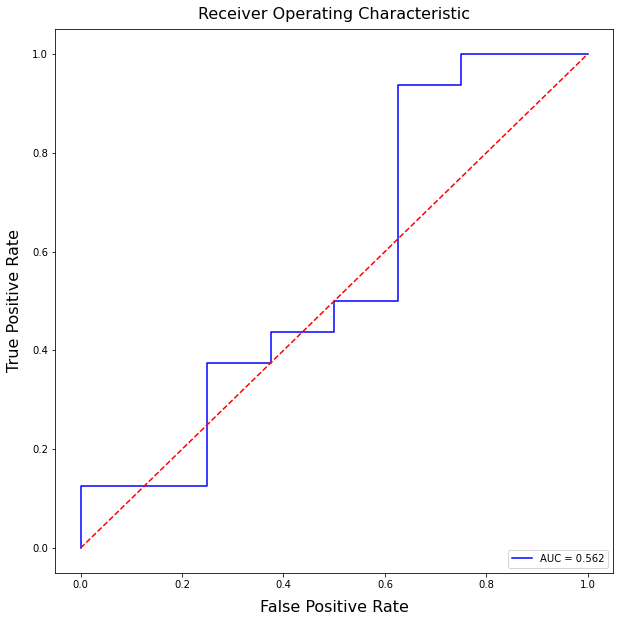

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

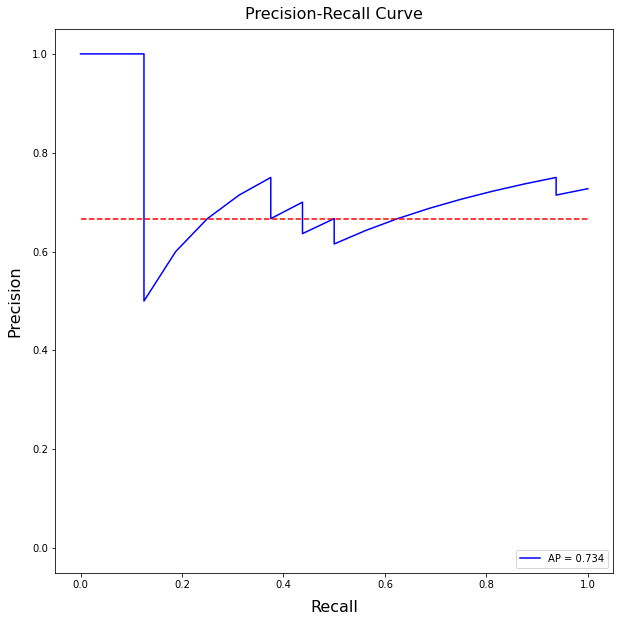

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [ ]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.542
Balanced  Accuracy: 0.521
Precision: 0.579
Recall: 0.681
F1 score: 0.626



Next, let's plot the roc curve spectra-wise:

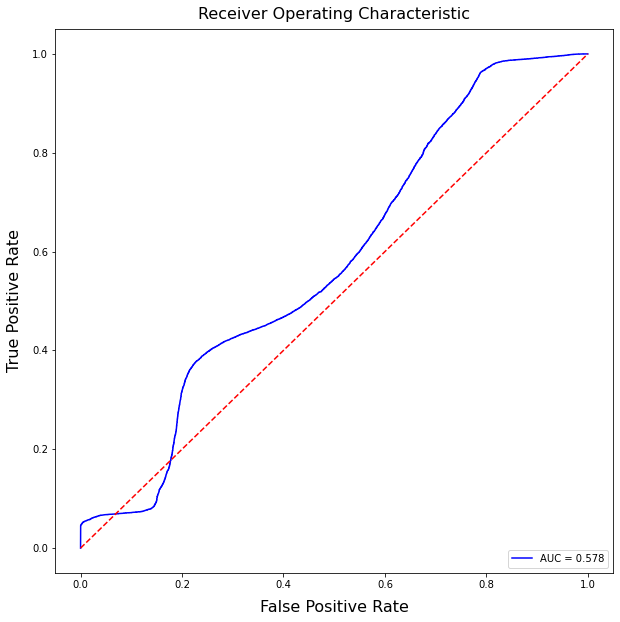

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

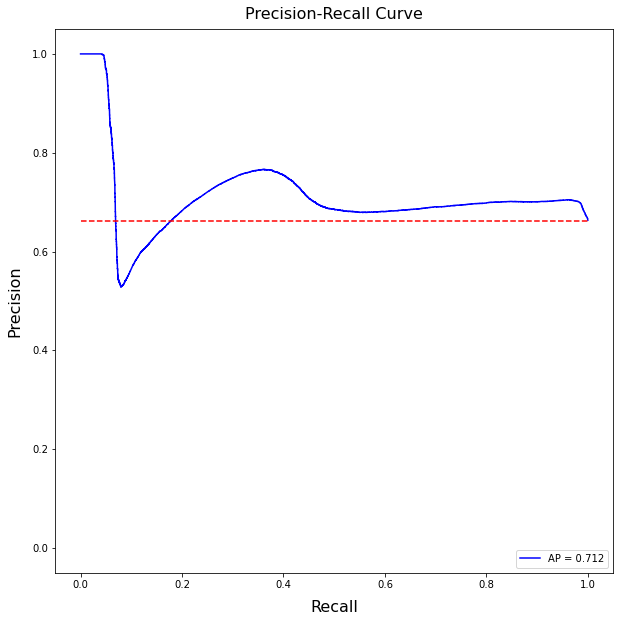

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

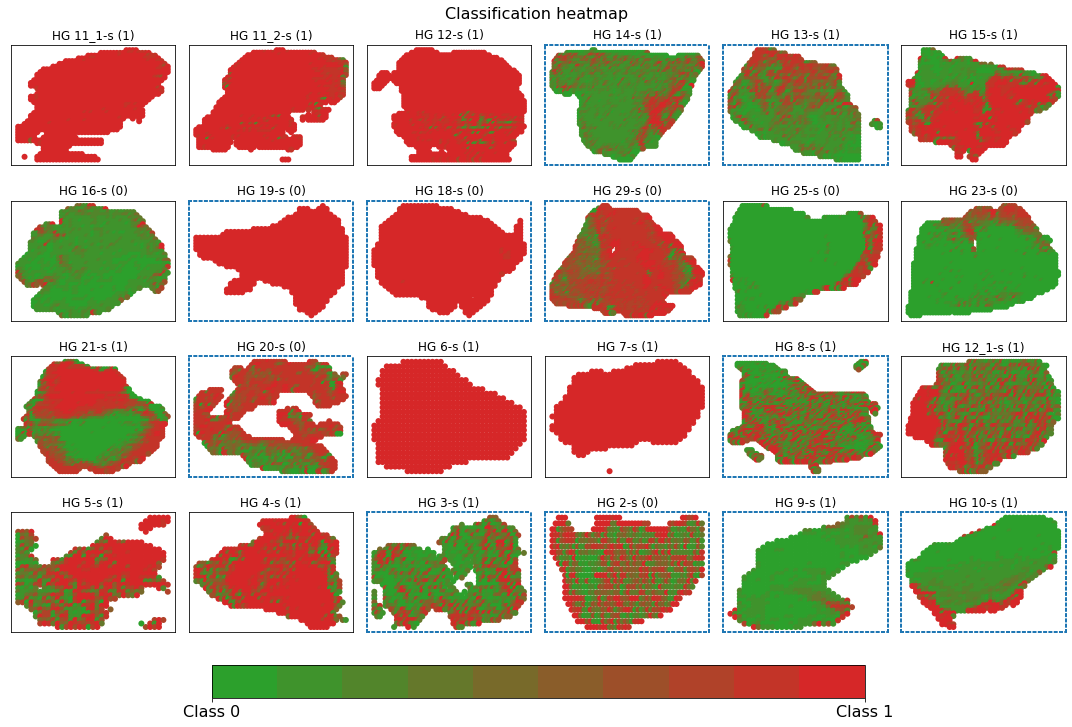

In [ ]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

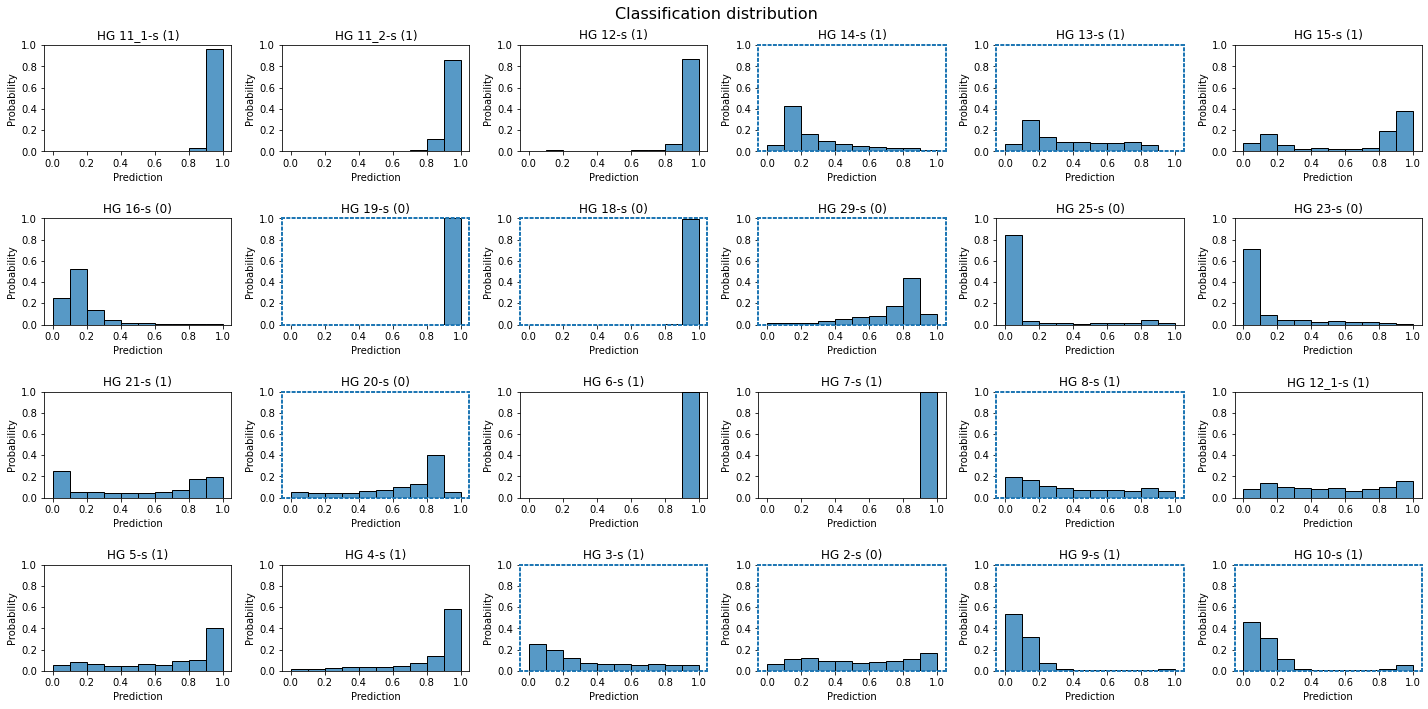

In [ ]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [ ]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on section non-tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [ ]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      ~s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [03:47<00:00,  9.48s/it]


Next, let's get some statistics about each left out section sample predictions:

In [ ]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_section_non_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.0847775638,0.9574870467,0.9249124527,0.8872208595,0.1231349781,1,1
HG 11_2-s,0.0801072791,0.9570156932,0.9244508743,0.8823903203,0.1287594289,1,1
HG 12-s,0.0821057111,0.9621397853,0.9231508374,0.8903226256,0.1100725830,1,1
HG 14-s,0.0089936443,0.9602779746,0.9432747960,0.8647179008,0.2259713560,1,1
HG 13-s,0.0503203087,0.9594881535,0.9413974881,0.8793902397,0.1807714403,1,1
HG 15-s,0.0481286757,0.9677744508,0.9468855858,0.8957933784,0.1681849509,1,1
HG 16-s,0.0665071383,0.9709687829,0.9452654719,0.9204553962,0.1070104316,0,1
HG 19-s,0.0871245489,0.9497818351,0.9462278485,0.9262959957,0.1220019832,0,1
HG 18-s,0.7003675103,0.9489277005,0.9463686347,0.9461623430,0.0060331775,0,1


Next, let's evaluate the classification performance image-wise:

In [ ]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_non_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.667
Balanced  Accuracy: 0.500
Precision: 0.667
Recall: 1.000
F1 score: 0.800



Next, let's plot the roc curve image-wise:

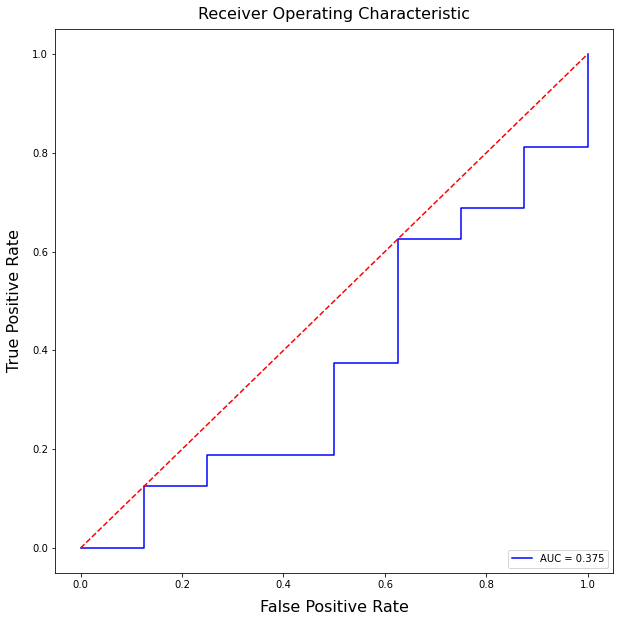

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

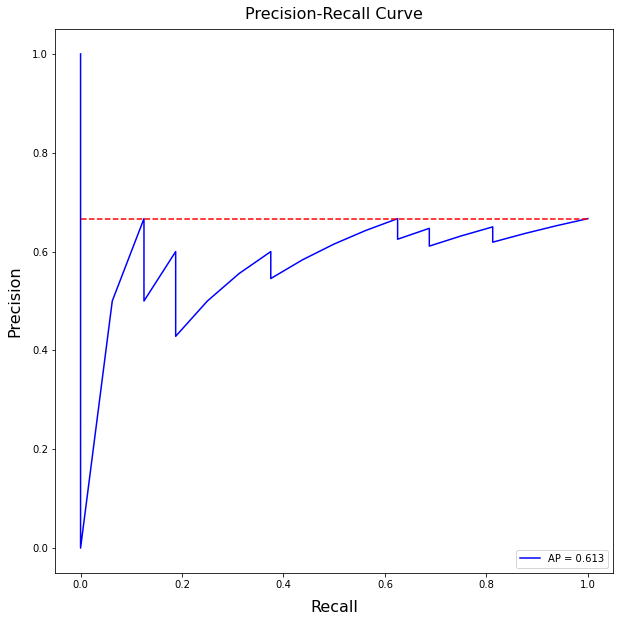

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [ ]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_non_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.567
Balanced  Accuracy: 0.412
Precision: 0.849
Recall: 0.617
F1 score: 0.715



Next, let's plot the roc curve spectra-wise:

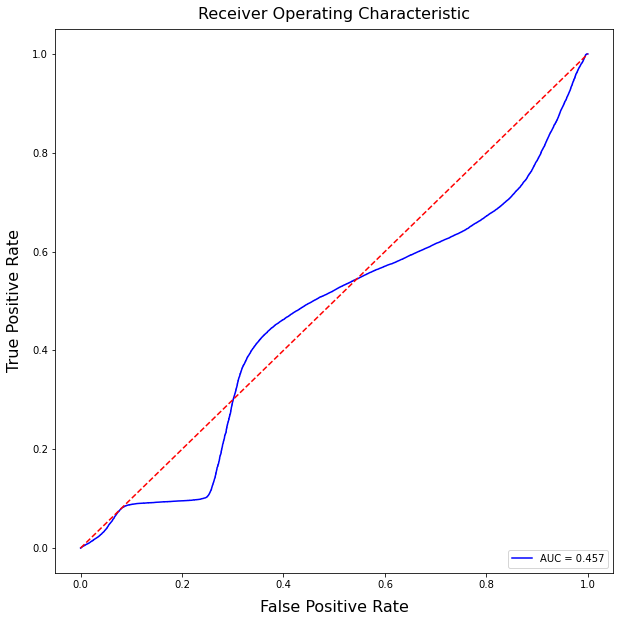

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

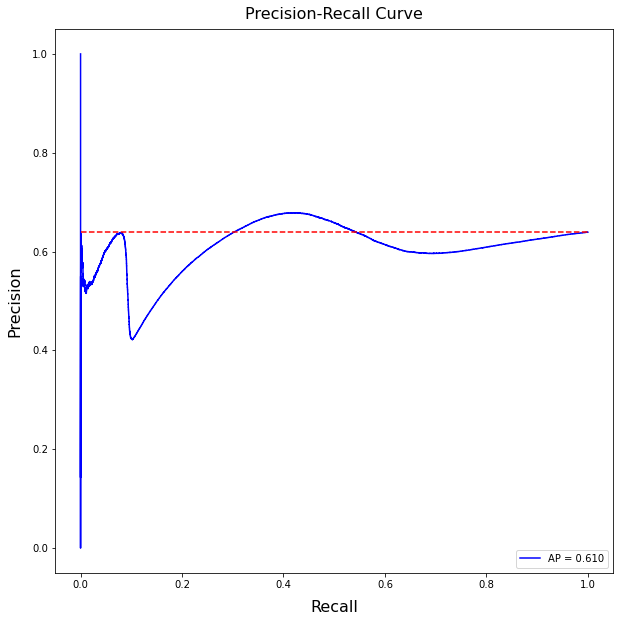

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

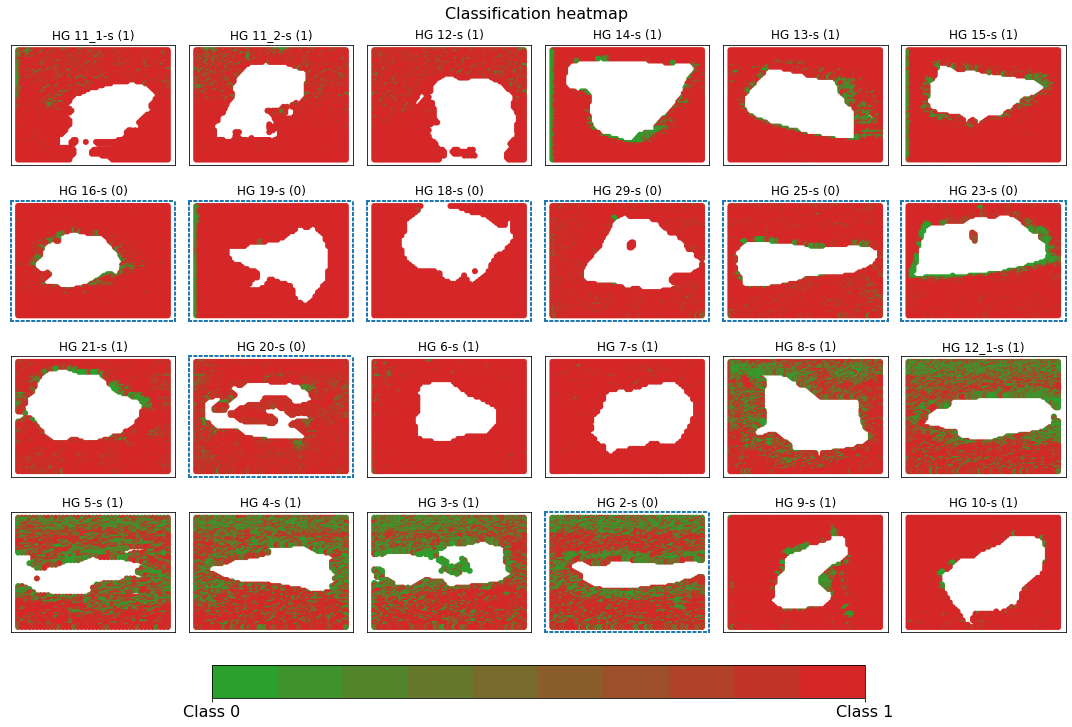

In [ ]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

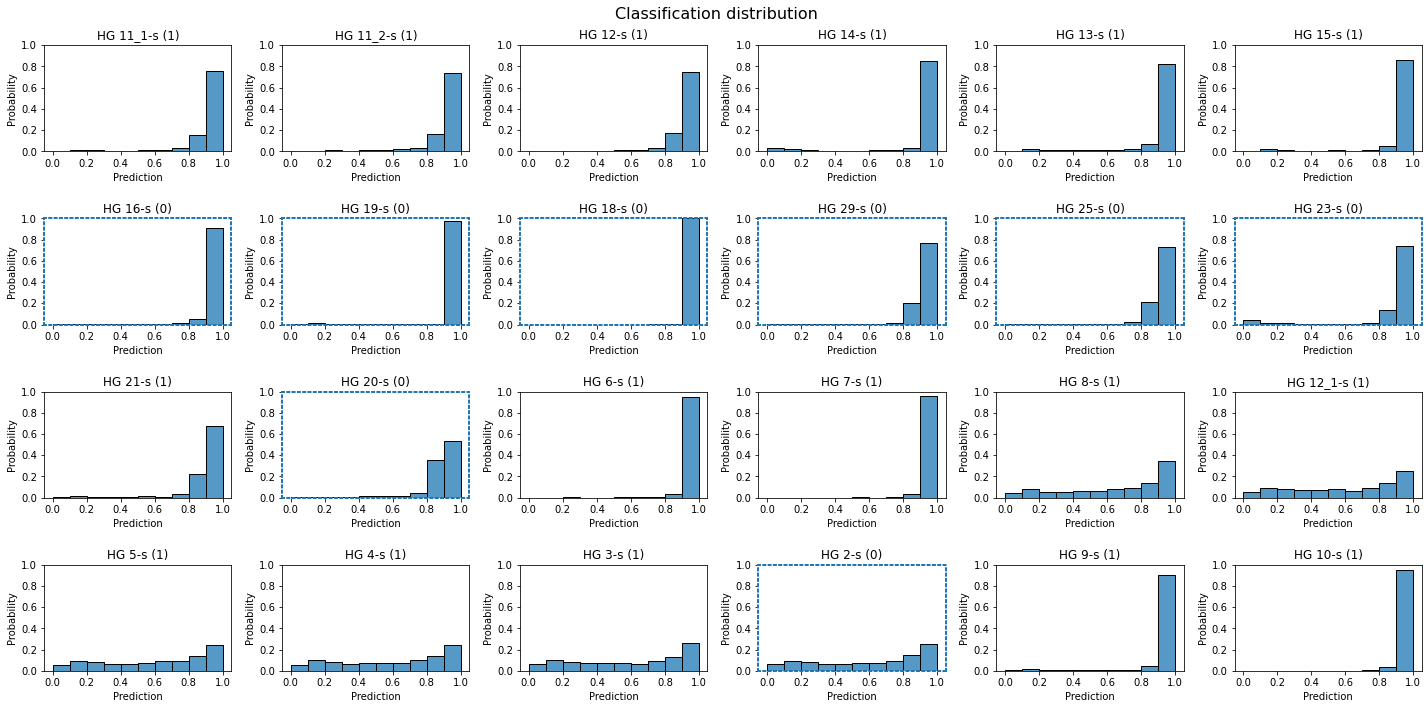

In [ ]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [ ]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on replica tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [ ]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the section sample_file_name
  s_file_name = s_metadata_df[s_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{s_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [03:01<00:00,  7.58s/it]


Next, let's get some statistics about each left out section sample predictions:

In [ ]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_replica_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 12-r,0.9054275751,0.9620789886,0.9476439953,0.9458902478,0.0074404539,1,1
HG 11-r,0.3832330406,0.9624625444,0.9374541640,0.9329466820,0.0332923457,1,1
HG 14-r,0.0343240984,0.9504333138,0.8679239750,0.6986250877,0.2938840389,1,1
HG 13-r,0.0412591659,0.9491196275,0.9072954655,0.8211230040,0.2056436986,1,1
HG 16-r,0.7177745104,0.9623435140,0.9487297535,0.9465688467,0.0140478797,0,1
HG 15-r,0.1585913152,0.9672718644,0.9494550228,0.9432899356,0.0406856872,1,1
HG 18_1-r,0.9449146986,0.9490683079,0.9465835094,0.9466718435,0.0003352958,0,1
HG 19-r,0.1409026682,0.9491294026,0.9467144012,0.9457715154,0.0257764719,0,1
HG 18_2-r,0.1422291696,0.9493883252,0.9473340511,0.9469906092,0.0145069771,0,1


Next, let's evaluate the classification performance image-wise:

In [ ]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_replica_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.625
Balanced  Accuracy: 0.522
Precision: 0.636
Recall: 0.933
F1 score: 0.757



Next, let's plot the roc curve image-wise:

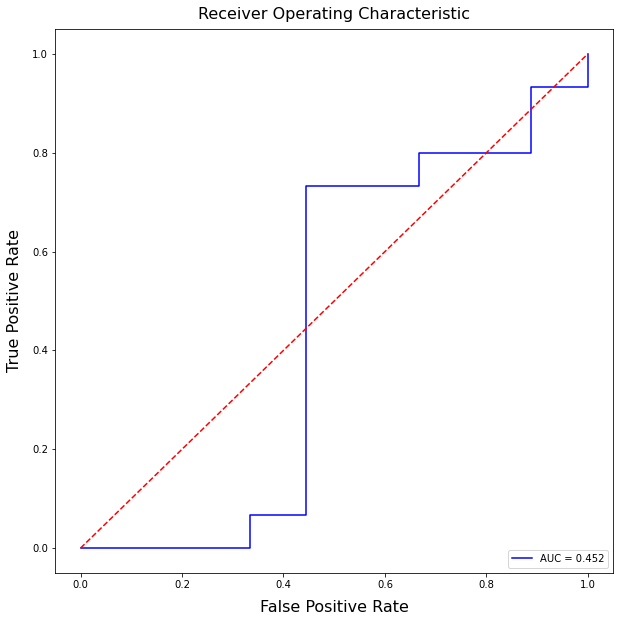

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

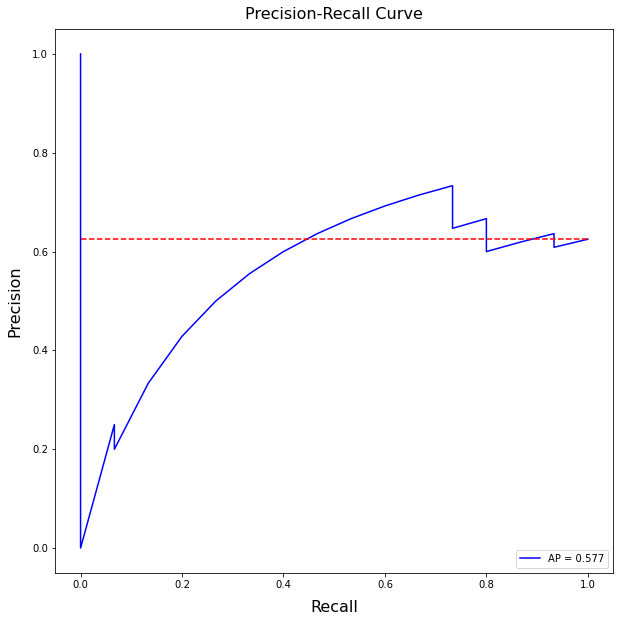

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [ ]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_replica_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.544
Balanced  Accuracy: 0.458
Precision: 0.846
Recall: 0.576
F1 score: 0.685



Next, let's plot the roc curve spectra-wise:

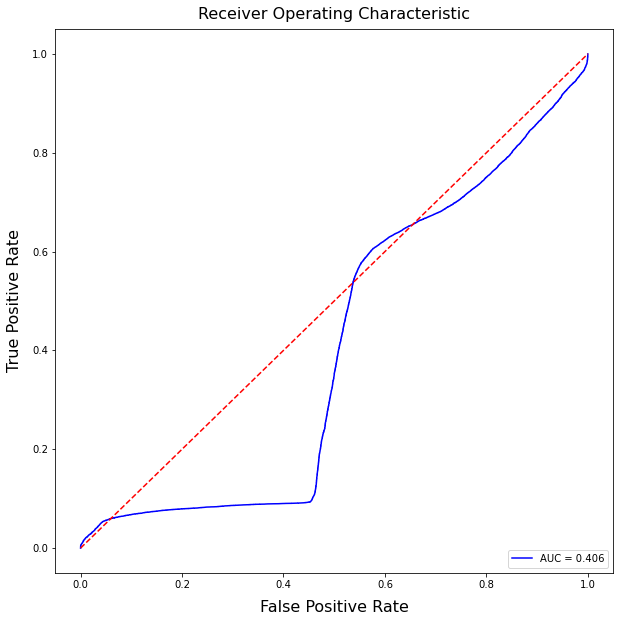

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

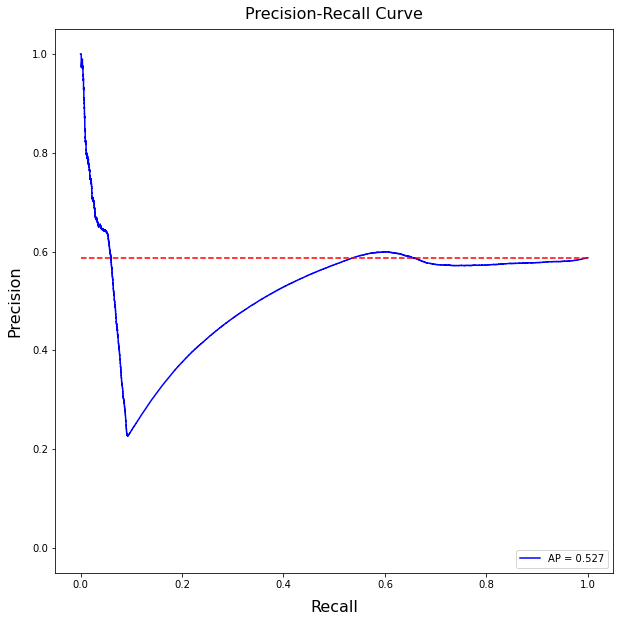

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

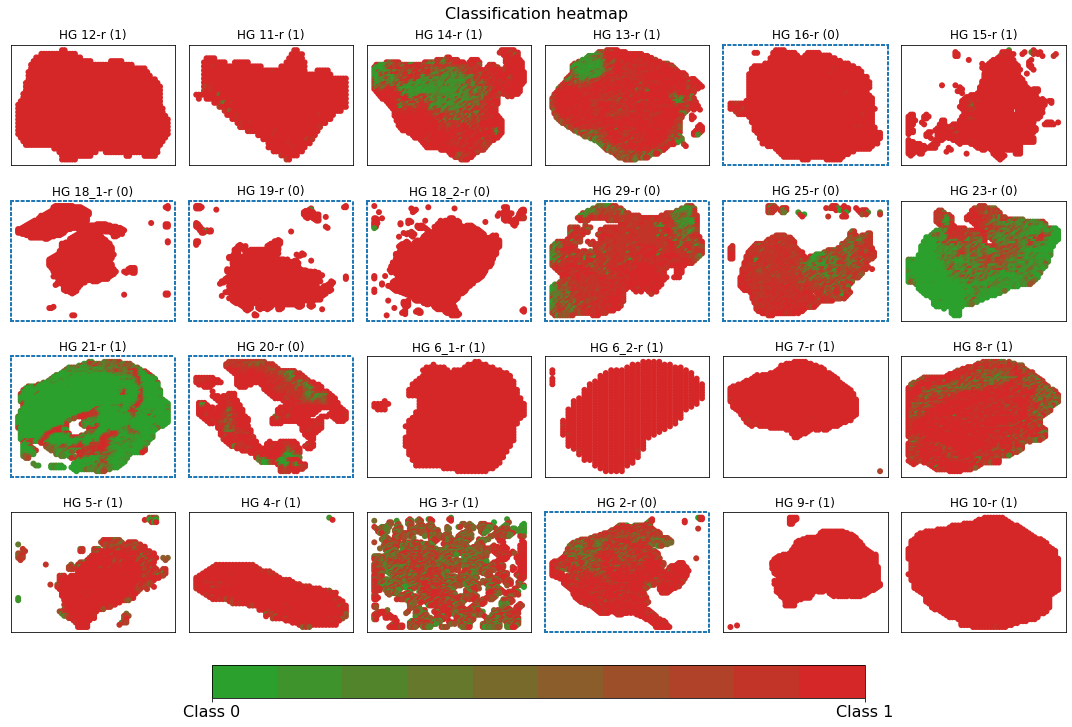

In [ ]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

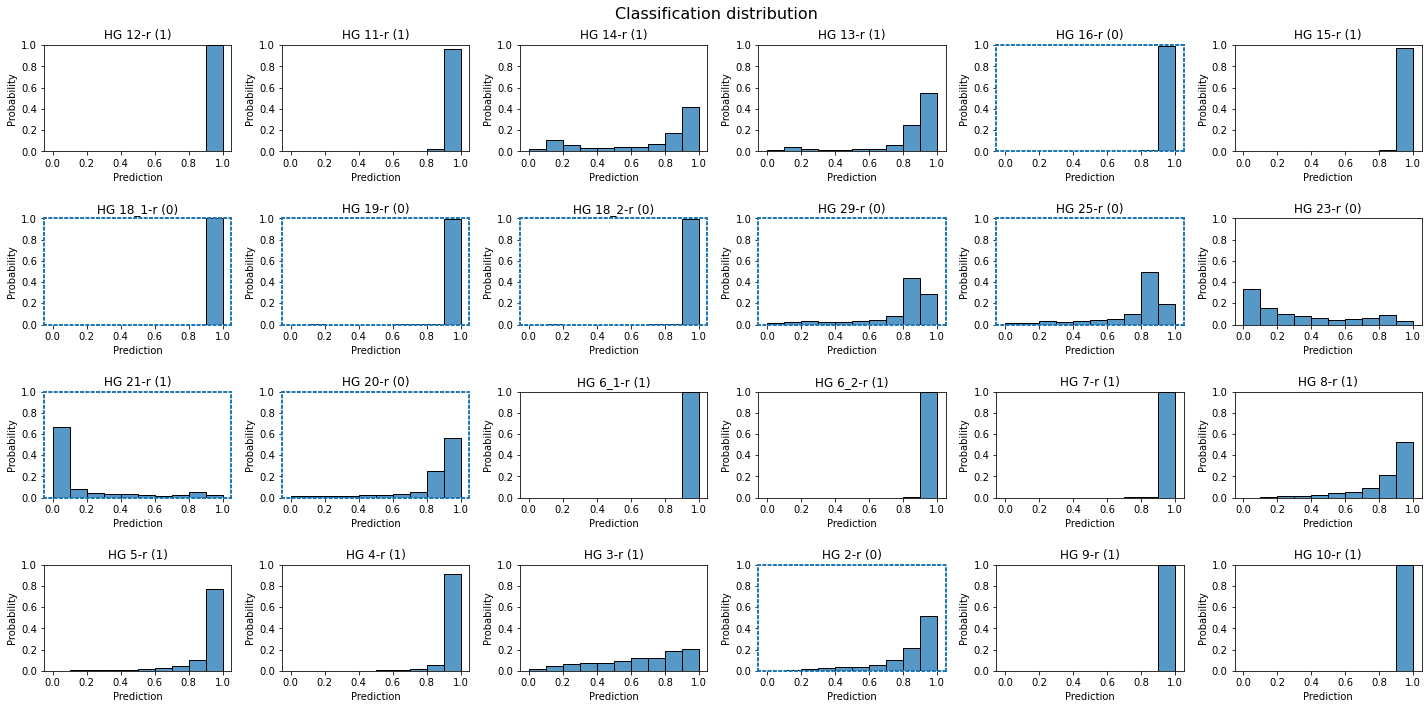

In [ ]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [ ]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on replica non-tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [ ]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the section sample_file_name
  s_file_name = s_metadata_df[s_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      ~r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{s_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [04:28<00:00, 11.21s/it]


Next, let's get some statistics about each left out section sample predictions:

In [ ]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_replica_non_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 12-r,0.0411824882,0.9627178311,0.9232611060,0.8984829783,0.1164360717,1,1
HG 11-r,0.0967801437,0.9624176025,0.9225432277,0.8729971051,0.1410767883,1,1
HG 14-r,0.0220761728,0.9628483057,0.9336067438,0.9219691157,0.0679633692,1,1
HG 13-r,0.1124880314,0.9618533850,0.9414297342,0.9149679542,0.0917952135,1,1
HG 16-r,0.0606295392,0.9716480970,0.9432532787,0.9249395728,0.0948892683,0,1
HG 15-r,0.0670855865,0.9760584235,0.9399902821,0.9285193086,0.0781535506,1,1
HG 18_1-r,0.0289990008,0.9496263862,0.9464277029,0.9384233952,0.0708047077,0,1
HG 19-r,0.0453008190,0.9490900040,0.9463854432,0.9346542954,0.0816871226,0,1
HG 18_2-r,0.0692518577,0.9489260912,0.9463873506,0.9373538494,0.0698086470,0,1


Next, let's evaluate the classification performance image-wise:

In [ ]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_replica_non_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.625
Balanced  Accuracy: 0.500
Precision: 0.625
Recall: 1.000
F1 score: 0.769



Next, let's plot the roc curve image-wise:

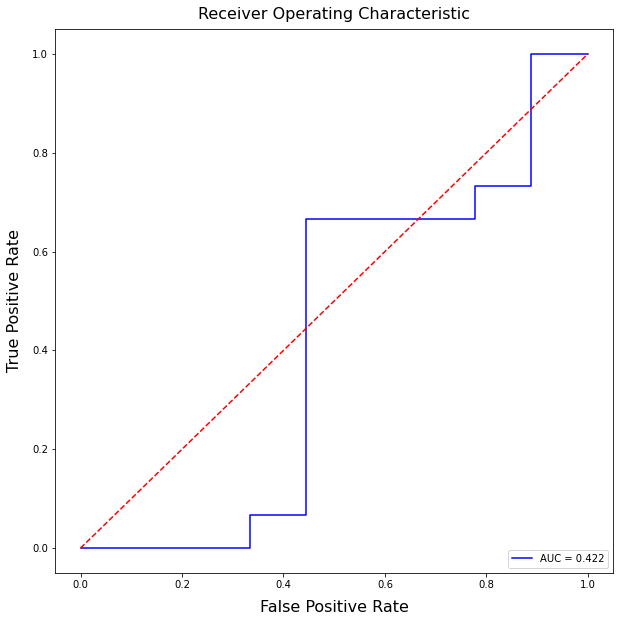

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

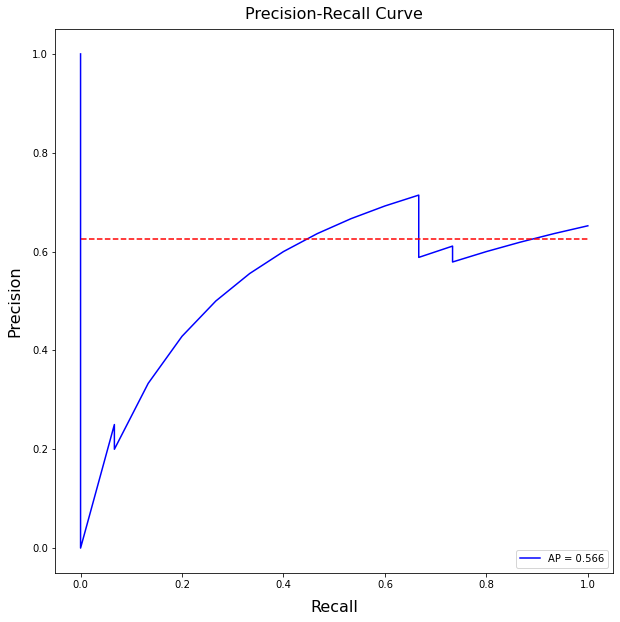

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [ ]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_replica_non_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.572
Balanced  Accuracy: 0.468
Precision: 0.923
Recall: 0.589
F1 score: 0.719



Next, let's plot the roc curve spectra-wise:

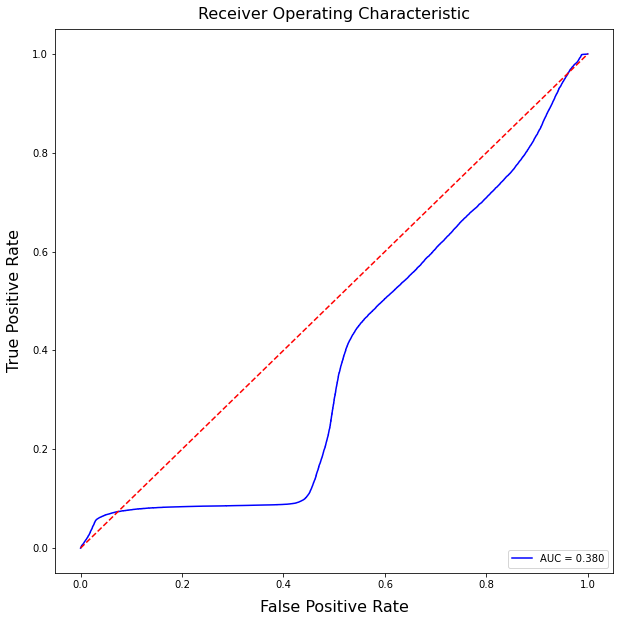

In [ ]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

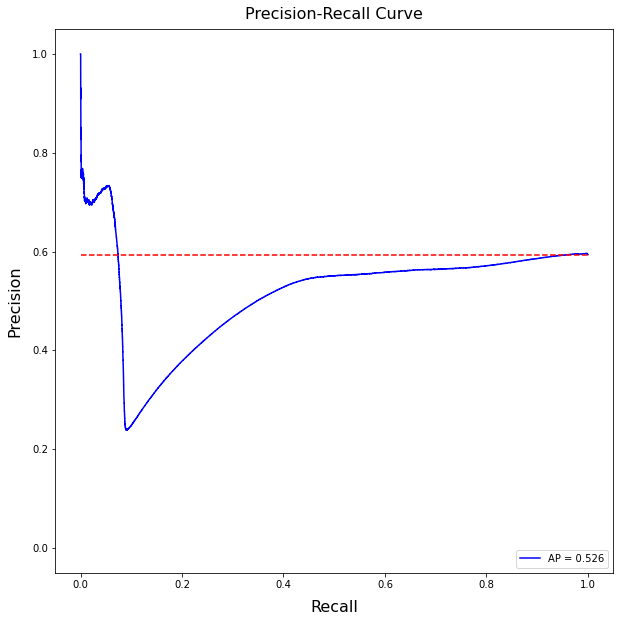

In [ ]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

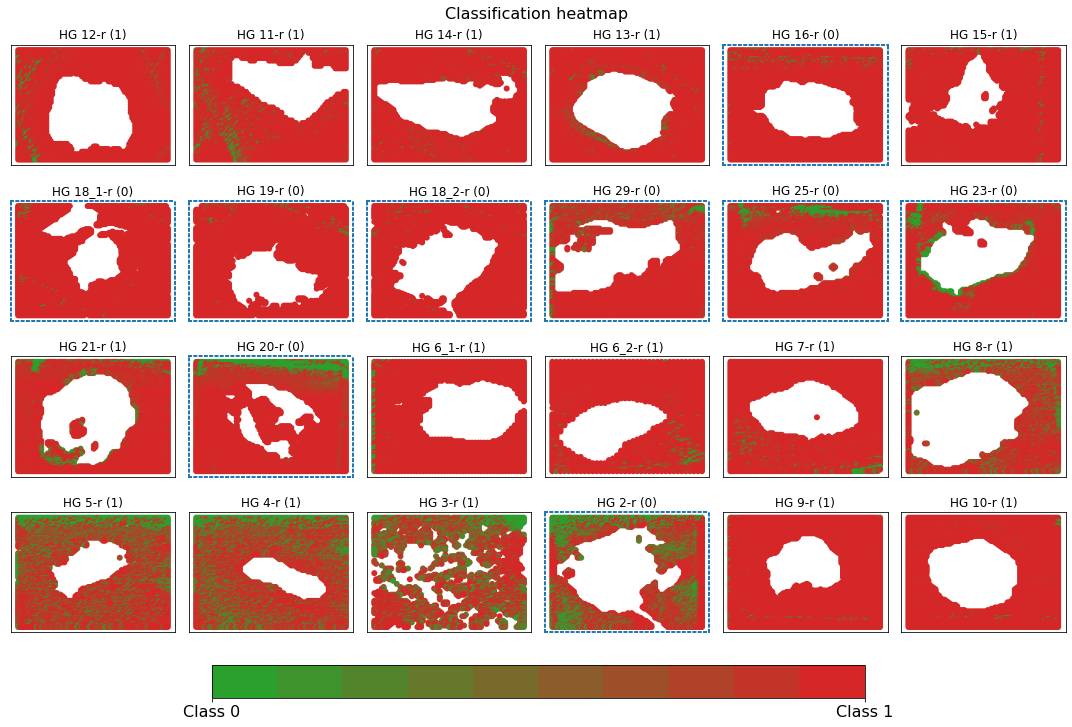

In [ ]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

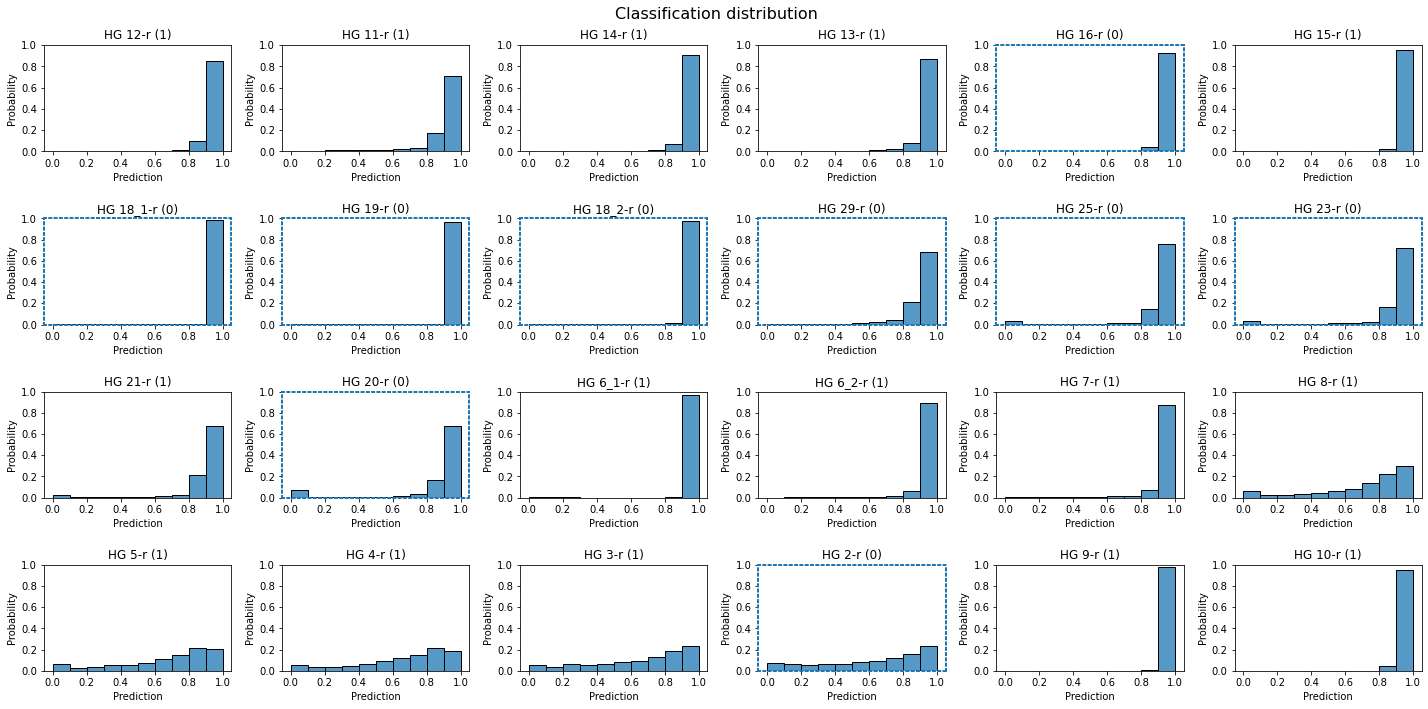

In [ ]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [ ]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [ ]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()